In [1]:
import os
import signal
import sys
import time

import example_robot_data
import numpy as np
import pinocchio as pin
import pinocchio.visualize

import crocoddyl

In [2]:
WITHDISPLAY = "display"

# Loading the anymal model
a1 = example_robot_data.load("a1")
rmodel = a1.model

lims = rmodel.effortLimit
lims *= 0.5  # reduced artificially the torque limits
rmodel.effortLimit = lims

lfFoot, rfFoot, lhFoot, rhFoot = "FL_foot", "FR_foot", "RL_foot", "RR_foot"
lfCalf, rfCalf, lhCalf, rhCalf = "FL_calf", "FR_calf", "RL_calf", "RR_calf"
body = "trunk"

rdata = rmodel.createData()
state = crocoddyl.StateMultibody(rmodel)
actuation = crocoddyl.ActuationModelFloatingBase(state)
lf_id = rmodel.getFrameId(lfFoot)
rf_id = rmodel.getFrameId(rfFoot)
lh_id = rmodel.getFrameId(lhFoot)
rh_id = rmodel.getFrameId(rhFoot)
body_id = rmodel.getFrameId(body)
lfcalf_id = rmodel.getFrameId(lfCalf)
rfcalf_id = rmodel.getFrameId(rfCalf)
lhcalf_id = rmodel.getFrameId(lhCalf)
rhcalf_id = rmodel.getFrameId(rhCalf)

_integrator = 'euler'
_control = 'one'

q0 = rmodel.referenceConfigurations["standing"]
rmodel.defaultState = np.concatenate([q0, np.zeros(rmodel.nv)])
x0 = rmodel.defaultState

In [3]:
contacts = crocoddyl.ContactModelMultiple(state, actuation.nu)
xref = np.array([0, 0.0, 0])
gains = np.array([0,0])
lf_contact = crocoddyl.ContactModel3D(
    state, 
    lf_id, 
    xref,
    pin.LOCAL_WORLD_ALIGNED,
    actuation.nu,
    gains
)
rf_contact = crocoddyl.ContactModel3D(
    state, 
    rf_id, 
    xref,
    pin.LOCAL_WORLD_ALIGNED,
    actuation.nu,
    gains
)
lh_contact = crocoddyl.ContactModel3D(
    state, 
    lh_id, 
    xref,
    pin.LOCAL_WORLD_ALIGNED,
    actuation.nu,
    gains
)
rh_contact = crocoddyl.ContactModel3D(
    state, 
    rh_id, 
    xref,
    pin.LOCAL_WORLD_ALIGNED,
    actuation.nu,
    gains
)
contacts.addContact("lf_contact", lf_contact)
contacts.addContact("rf_contact", rf_contact)
contacts.addContact("lh_contact", lh_contact)
contacts.addContact("rh_contact", rh_contact)

In [8]:
from utils.transforms import rpy_to_quaternion, csquat_to_rpy, csrpy_to_quat, quat_to_rpy
from utils.costs import handstand, crouch, add_lf_cost
from utils.cimpc import cimpc, cimpc_adaptive
from utils.models import ContactModel, IAM_shoot

In [12]:
display = crocoddyl.MeshcatDisplay(a1)
display.rate = -1
display.freq = 1
display.robot.viewer.jupyter_cell()


ImportError: Error while importing the viewer client.
Check whether meshcat is properly installed (pip install --user meshcat).

In [ ]:
%load_ext line_profiler
from utils.models import DAM_contact
def test_fun():
    costs_r,costs_t = handstand(rmodel, state, actuation)

    DT, N = 2.5e-2, 20
    rho = 0 # 脚离地
    contact_ids = [lf_id, rf_id, lh_id, rh_id]
    # [lfcalf_id, rfcalf_id, lhcalf_id, rhcalf_id]
    contact_model = ContactModel(state,contact_ids)
    # 减少滑动
    add_lf_cost(costs_r,state,actuation,contact_ids)
    actionmodels = IAM_shoot(N,state, actuation, (costs_r,costs_t), contact_model, DT, rho)

    # actionmodels = IAM_ccdContactFwd(N, state, actuation, (costs_r,costs_t), contacts, DT)
    # actionmodels = IAM_ccdFreeFwd(N, state, actuation, (costs_r,costs_t), DT)

    maxiter = 1
    is_feasible = False
    init_reg = 0.1

    problem = crocoddyl.ShootingProblem(x0, actionmodels[:-1], actionmodels[-1])
    solver = crocoddyl.SolverFDDP(problem)
    # 调cost权重，提前测试空中不会乱动
    x00 = x0.copy()
    x00[2] += 0.1
    xs = [x00] * (solver.problem.T + 1) # list of array即可
    us = [np.zeros(12)] * solver.problem.T

    # x0 = rmodel.defaultState
    # xs = [x0] * (solver.problem.T + 1)
    
    # ustatic = solver.problem.quasiStatic([x0] * solver.problem.T) # 初始化很重要,但要很长时间算
    # us = [ustatic[0]]*solver.problem.T

    print('Initialization success !')
    solver.solve(xs, us, maxiter, is_feasible, init_reg)

    return 0
test_fun()
%lprun -T line_profiler_output.txt -f DAM_contact.collision_test -f DAM_contact.calc -f DAM_contact.calcDiff test_fun()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
Initialization success !
Initialization success !

*** Profile printout saved to text file 'line_profiler_output.txt'. 


Timer unit: 1e-09 s

Total time: 0.0469058 s
File: /home/joshua/WORK/test_genesis/cimpc/utils/models.py
Function: collision_test at line 120

Line #      Hits         Time  Per Hit   % Time  Line Contents
   120                                               @profile
   121                                               def collision_test(self,data,tau,v):
   122                                                   
   123       370     126653.0    342.3      0.3          for i, contact_id in enumerate(self.contact_ids):
   124       296     299033.0   1010.2      0.6              oMf = data.pinocchio.oMf[contact_id]
   125       296     134297.0    453.7      0.3              pos = oMf.translation
   126       296     171139.0    578.2      0.4              rot = oMf.rotation
   127       296     469461.0   1586.0      1.0              self.contact_objects[i].setTransform(coal.Transform3s(rot, pos))
   128                                                       
   129       296    3775077.0

Initialization success !
iter    cost       merit      stop       grad       preg       dreg      step   ||ffeas||  ||gfeas||  ||hfeas||   dV-exp       dV      dPhi-exp     dPhi
   0  2.243e+04  0.000e+00  5.742e+03  5.418e+04  1.000e-01  1.000e-01  0.2500  2.064e+00  0.000e+00  0.000e+00  6.334e+03  1.438e+03  0.000e+00  0.000e+00
   1  1.809e+04  0.000e+00  9.427e+03  4.189e+04  1.000e-01  1.000e-01  0.2500  1.548e+00  0.000e+00  0.000e+00  6.219e+03  4.340e+03  0.000e+00  0.000e+00
   2  1.242e+04  0.000e+00  1.328e+04  3.759e+04  1.000e-01  1.000e-01  0.2500  1.161e+00  0.000e+00  0.000e+00  6.666e+03  5.677e+03  0.000e+00  0.000e+00
   3  9.832e+03  0.000e+00  1.004e+04  2.590e+04  1.000e-01  1.000e-01  0.1250  8.708e-01  0.000e+00  0.000e+00  2.640e+03  2.585e+03  0.000e+00  0.000e+00
   4  9.324e+03  0.000e+00  8.170e+03  2.109e+04  1.000e-01  1.000e-01  0.0312  7.619e-01  0.000e+00  0.000e+00  5.725e+02  5.076e+02  0.000e+00  0.000e+00
   5  9.202e+03  0.000e+00  7.747e+03  1.9

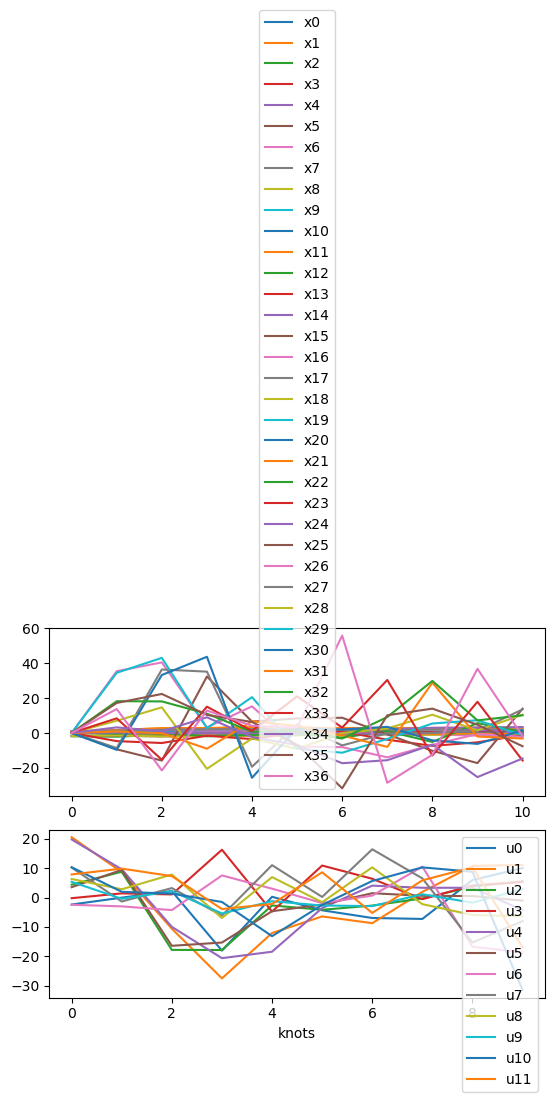

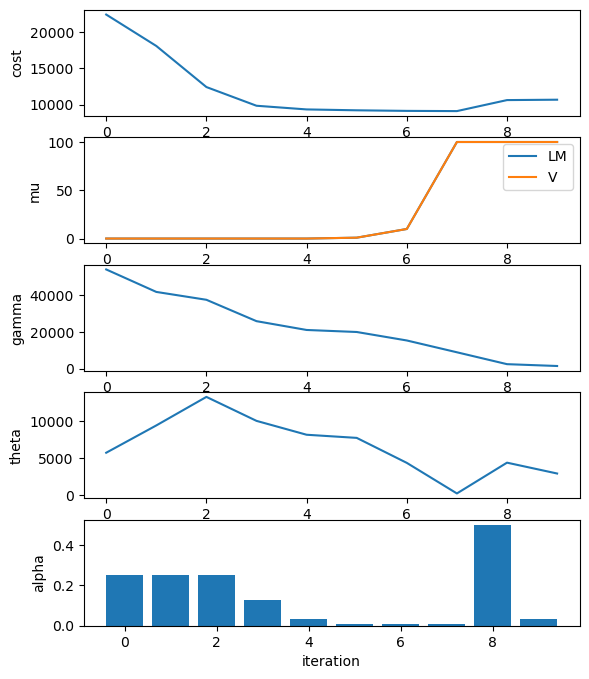

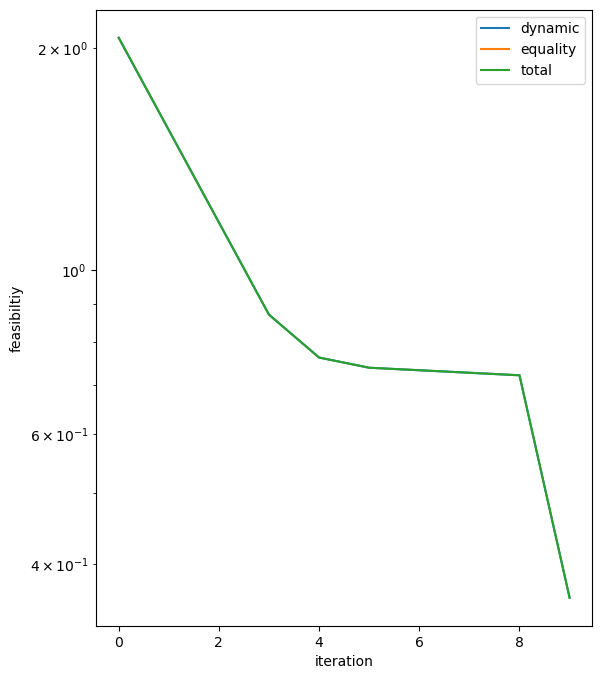

In [47]:
import importlib
import utils.costs
importlib.reload(utils.costs)
from utils.costs import handstand, upright, crouch, walking, jumping, add_lf_cost
import utils.models
importlib.reload(utils.models)
from utils.models import IAM_shoot, IAM_ccdContactFwd, IAM_ccdFreeFwd

costs_r,costs_t = upright(rmodel, state, actuation)

DT, N = 2.5e-2, 10
rho = 1 # 脚离地
contact_ids = [lf_id, rf_id, lh_id, rh_id]
# [lfcalf_id, rfcalf_id, lhcalf_id, rhcalf_id]
contact_model = ContactModel(state,contact_ids)
# 减少滑动
add_lf_cost(costs_r,state,actuation,contact_ids)
actionmodels = IAM_shoot(N,state, actuation, (costs_r,costs_t), contact_model, DT, rho)

# actionmodels = IAM_ccdContactFwd(N, state, actuation, (costs_r,costs_t), contacts, DT)
# actionmodels = IAM_ccdFreeFwd(N, state, actuation, (costs_r,costs_t), DT)

maxiter = 10
is_feasible = False
init_reg = 0.1

problem = crocoddyl.ShootingProblem(x0, actionmodels[:-1], actionmodels[-1])
solver = crocoddyl.SolverFDDP(problem)
log = crocoddyl.CallbackLogger()
solver.setCallbacks([log,crocoddyl.CallbackVerbose(),crocoddyl.CallbackDisplay(display)])

# 调cost权重，提前测试空中不会乱动
x00 = x0.copy()
# x00[2] += 0.1
xs = [x00] * (solver.problem.T + 1) # list of array即可
us = [np.zeros(12)] * solver.problem.T

# x0 = rmodel.defaultState
# xs = [x0] * (solver.problem.T + 1)
# ustatic = solver.problem.quasiStatic([x0] * solver.problem.T) # 初始化很重要,但要很长时间算
# us = [ustatic[0]]*solver.problem.T

print('Initialization success !')
solver.solve(xs, us, maxiter, is_feasible, init_reg)

print('Initial cost: ', solver.cost)
crocoddyl.plotOCSolution(log.xs, log.us)
crocoddyl.plotConvergence(
    log.costs, log.pregs, log.dregs, log.grads, log.stops, log.steps
)
crocoddyl.plotFeasibility(log.ffeass,log.hfeass)

In [35]:
from utils.costs import handstand, upright, crouch, add_lf_cost
costs_r,costs_t = upright(rmodel, state, actuation)

DT, N = 2.5e-2, 20
rho = 1 # 显著影响cost..., cost不收敛就要加大cost权重
# actionmodels = IAM_ccd(N,state, actuation, costs, contacts, DT)
contact_ids = [lf_id, rf_id, lh_id, rh_id,
               ]# , lfcalf_id, rfcalf_id, lhcalf_id, rhcalf_id]
contact_model = ContactModel(state,contact_ids)
add_lf_cost(costs_r,state,actuation,contact_ids) # 感觉没啥影响...
# actionmodels = IAM_contact(N,state, actuation, costs_t, contact_model, DT, rho)
actionmodels = IAM_shoot(N,state, actuation, [costs_r,costs_t], contact_model, DT, rho)

x_traj, u_traj = cimpc(0.5, x0, actionmodels)

Initialization success !
Initial cost: 11945.35124022049


  5%|▌         | 1/20 [00:01<00:33,  1.75s/it]

Step 1, cost: 7419.444117102272


 10%|█         | 2/20 [00:05<00:50,  2.81s/it]

Step 2, cost: 8227.685511981575


 15%|█▌        | 3/20 [00:07<00:44,  2.63s/it]

Step 3, cost: 3696.0394442834627


 20%|██        | 4/20 [00:12<00:55,  3.48s/it]

Step 4, cost: 2743.5416253206845


 25%|██▌       | 5/20 [00:14<00:46,  3.08s/it]

Step 5, cost: 20937.69243926128


 30%|███       | 6/20 [00:16<00:38,  2.73s/it]

Step 6, cost: 5992.598811275354


 35%|███▌      | 7/20 [00:19<00:34,  2.62s/it]

Step 7, cost: 2849.920423539528


 40%|████      | 8/20 [00:21<00:31,  2.63s/it]

Step 8, cost: 2640.8540686819


 45%|████▌     | 9/20 [00:25<00:30,  2.78s/it]

Step 9, cost: 2628.200825578635


 50%|█████     | 10/20 [00:27<00:27,  2.76s/it]

Step 10, cost: 2616.9543820140725


 55%|█████▌    | 11/20 [00:29<00:22,  2.54s/it]

Step 11, cost: 11221.623539312302


 60%|██████    | 12/20 [00:32<00:19,  2.48s/it]

Step 12, cost: 10904.063950518092


 65%|██████▌   | 13/20 [00:33<00:15,  2.20s/it]

Step 13, cost: 10942.237792149313


 70%|███████   | 14/20 [00:34<00:11,  1.87s/it]

Step 14, cost: 9246.29274884445


 75%|███████▌  | 15/20 [00:35<00:08,  1.63s/it]

Step 15, cost: 9261.07514910581


 80%|████████  | 16/20 [00:36<00:05,  1.44s/it]

Step 16, cost: 10039.001295583384


 85%|████████▌ | 17/20 [00:38<00:04,  1.40s/it]

Step 17, cost: 7911.103034559587


 90%|█████████ | 18/20 [00:39<00:02,  1.36s/it]

Step 18, cost: 9768.609780012199


 95%|█████████▌| 19/20 [00:39<00:01,  1.03s/it]

Step 19, cost: 2757.2217874388652


100%|██████████| 20/20 [00:40<00:00,  2.00s/it]

Step 20, cost: 757.2325518644662


In [36]:
dts = [DT*10] * len(x_traj)
display.display(x_traj, dts, [], [], [], [], [], dts, 1)

In [37]:
costs_r,costs_t = handstand(rmodel, state, actuation)

DT, N = 2.5e-2, 20
rho = 0.1 # 大一点cost突然下降
# actionmodels = IAM_ccd(N,state, actuation, costs, contacts, DT)
contact_ids = [lf_id, rf_id, lh_id, rh_id,
               ]# , lfcalf_id, rfcalf_id, lhcalf_id, rhcalf_id]
contact_model = ContactModel(state,contact_ids)
# 的确减少滑动了, 不滑动算的更快
add_lf_cost(costs_r,state,actuation,contact_ids)

# actionmodels = IAM_contact(N,state, actuation, costs, contact_model, DT, 0.1)
action_component = [N,state, actuation, [costs_r,costs_t], contact_model, DT, rho]

x_traj, u_traj = cimpc_adaptive(1, x0, action_component)

Initialization success !
Initial cost: 65354.96667320423


  2%|▎         | 1/40 [00:17<11:10, 17.19s/it]

Step 1, cost: 57414.90624289606


  5%|▌         | 2/40 [00:39<12:43, 20.08s/it]

Step 2, cost: 55334.791452842604


  8%|▊         | 3/40 [00:57<11:48, 19.16s/it]

Step 3, cost: 53975.98015118236


 10%|█         | 4/40 [01:21<12:38, 21.06s/it]

Step 4, cost: 53967.56218389942


 12%|█▎        | 5/40 [01:42<12:21, 21.19s/it]

Step 5, cost: 53959.23450141647


 15%|█▌        | 6/40 [02:06<12:34, 22.19s/it]

Step 6, cost: 53951.08169539992


 18%|█▊        | 7/40 [02:37<13:37, 24.79s/it]

Step 7, cost: 53943.19471513938


 18%|█▊        | 7/40 [02:40<12:35, 22.89s/it]


KeyboardInterrupt: 

In [36]:
dts = [DT*10] * len(x_traj)
display.display(x_traj, dts, [], [], [], [], [], dts, 1)